In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import h5py

from skimage import transform

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [9]:
def load_h5_dataset(location):
    train_dataset = h5py.File(location[0], 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    
    test_dataset = h5py.File(location[1], 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    classes = np.array(test_dataset["list_classes "][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_h5_dataset(['datasets/train_signs.h5', 'datasets/test_signs.h5'])
print(X_train_orig.shape, Y_train_orig.shape)

(1080, 64, 64, 3) (1, 1080)


In [133]:
# def apply_data_augmentation(images, labels):
#     augmented_images = []
#     augmented_labels = []

#     for image, label in zip(images, labels):
#         # Horizontal flip
#         flipped_image = np.fliplr(image)
#         augmented_images.append(flipped_image)
#         augmented_labels.append(label)

#         # Rotate left (counter-clockwise) by 45 degrees
#         rotated_left = transform.rotate(image, angle=45, mode='reflect')
#         augmented_images.append(rotated_left)
#         augmented_labels.append(label)

#         # Rotate right (clockwise) by 45 degrees
#         rotated_right = transform.rotate(image, angle=-45, mode='reflect')
#         augmented_images.append(rotated_right)
#         augmented_labels.append(label)

#     augmented_images = np.array(augmented_images)
#     augmented_labels = np.array(augmented_labels)
    
#     return augmented_images, augmented_labels

# def augment_and_shuffle(images, labels):
#     augmented_images, augmented_labels = apply_data_augmentation(images, labels)
    
#     combined_images = np.concatenate((images, augmented_images))
#     combined_labels = np.concatenate((labels, augmented_labels))
    
#     indices = np.arange(combined_images.shape[0])
#     np.random.shuffle(indices)
    
#     shuffled_images = combined_images[indices]
#     shuffled_labels = combined_labels[indices]
    
#     return shuffled_images, shuffled_labels.reshape((1, -1))

# X_train_orig, Y_train_orig = augment_and_shuffle(X_train, Y_train.reshape(-1))
# X_test_orig, Y_test_orig = augment_and_shuffle(X_test, Y_test.reshape(-1)) 

# print(X_train_orig.shape, Y_train_orig.shape)

y = 5


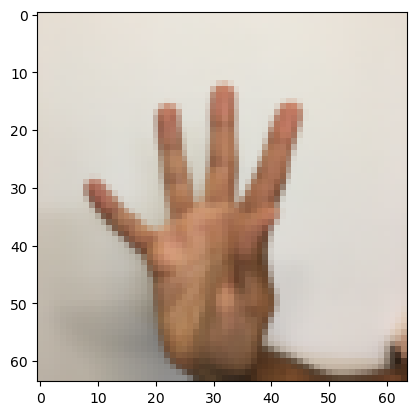

In [148]:
index = 12

plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [23]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [14]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size =f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [19]:
def convolutional_block(X, f, filters, s=2, training =True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size =f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [20]:
def ResNet50(input_shape= (64, 64, 3), classes=6):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = convolutional_block(X, f=3, s=2, filters=[128, 128, 512])
    
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, f=3, s=2, filters=[256, 256, 1024])
    
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    X = convolutional_block(X, f=3, s=2, filters=[512, 512, 2048])
    
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [21]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 32, 64)           256       ['conv2d_1[0][0]']        

 activation_8 (Activation)   (None, 15, 15, 64)           0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 15, 15, 64)           36928     ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_10 (Ba  (None, 15, 15, 64)           256       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_9 (Activation)   (None, 15, 15, 64)           0         ['batch_normalization_10[0][0]
                                                                    ']                            
          

                                                                                                  
 batch_normalization_19 (Ba  (None, 8, 8, 128)            512       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 8, 8, 128)            0         ['batch_normalization_19[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 8, 8, 128)            147584    ['activation_17[0][0]']       
                                                                                                  
 batch_normalization_20 (Ba  (None, 8, 8, 128)            512       ['conv2d_20[0][0]']           
 tchNormal

                                                                                                  
 activation_25 (Activation)  (None, 4, 4, 1024)           0         ['add_7[0][0]']               
                                                                                                  
 conv2d_29 (Conv2D)          (None, 4, 4, 256)            262400    ['activation_25[0][0]']       
                                                                                                  
 batch_normalization_29 (Ba  (None, 4, 4, 256)            1024      ['conv2d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_26 (Activation)  (None, 4, 4, 256)            0         ['batch_normalization_29[0][0]
                                                                    ']                            
          

                                                                                                  
 conv2d_38 (Conv2D)          (None, 4, 4, 256)            262400    ['activation_34[0][0]']       
                                                                                                  
 batch_normalization_38 (Ba  (None, 4, 4, 256)            1024      ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 4, 4, 256)            0         ['batch_normalization_38[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 4, 4, 256)            590080    ['activation_35[0][0]']       
          

                                                                     'batch_normalization_47[0][0]
                                                                    ']                            
                                                                                                  
 activation_43 (Activation)  (None, 2, 2, 2048)           0         ['add_13[0][0]']              
                                                                                                  
 conv2d_48 (Conv2D)          (None, 2, 2, 512)            1049088   ['activation_43[0][0]']       
                                                                                                  
 batch_normalization_48 (Ba  (None, 2, 2, 512)            2048      ['conv2d_48[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 77s 2s/step - loss: 1.7419 - accuracy: 0.4787
Epoch 2/10
34/34 [==============================] - 64s 2s/step - loss: 1.3667 - accuracy: 0.7269
Epoch 3/10
34/34 [==============================] - 61s 2s/step - loss: 2.6249 - accuracy: 0.5241
Epoch 4/10
34/34 [==============================] - 60s 2s/step - loss: 1.2173 - accuracy: 0.5500
Epoch 5/10
34/34 [==============================] - 64s 2s/step - loss: 1.0081 - accuracy: 0.6537
Epoch 6/10
34/34 [==============================] - 63s 2s/step - loss: 0.6822 - accuracy: 0.7769
Epoch 7/10
34/34 [==============================] - 68s 2s/step - loss: 0.3669 - accuracy: 0.8704
Epoch 8/10
34/34 [==============================] - 68s 2s/step - loss: 0.2619 - accuracy: 0.9130
Epoch 9/10
34/34 [==============================] - 67s 2s/step - loss: 0.2558 - accuracy: 0.9194
Epoch 10/10
34/34 [==============================] - 65s 2s/step - loss: 0.2460 - accuracy: 0.9287


In [1]:
model.save("hand_digit_resnet_version.keras")

NameError: name 'model' is not defined

In [2]:
import os
import cv2
import time

model = tf.keras.models.load_model("hand_digit_resnet_version.keras")

def Predict_digit(image_location):
#     original_image = cv2.imread(f"{os.getcwd()}/{image_location}")
    original_image = image_location
    target_size = (64, 64)
    resized_image = cv2.resize(original_image, target_size)
    padded_image = np.zeros((1, target_size[0], target_size[1], 3), dtype=np.uint8)
    pad_height = (target_size[0] - resized_image.shape[0]) // 2
    pad_width = (target_size[1] - resized_image.shape[1]) // 2
    padded_image[0, pad_height:pad_height + resized_image.shape[0], pad_width:pad_width + resized_image.shape[1], :] = resized_image
    image = padded_image
    image = image/255
    result = model.predict(image)
    return str(np.argmax(result))

In [3]:
cap = cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)   
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) 
cap.set(cv2.CAP_PROP_FPS, 15)  

if not cap.isOpened():
    print("Error: Could not open caqmera.")
    exit()
    
while True:
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    if not ret:
        print("Error: Could not read frame.")
        break
    
    text = Predict_digit(frame)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  
    thickness = 2
    position = (10, 50) 
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.imshow("Inference", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 34ms/step
